In [1]:
import os
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
import dotenv
import collections
from snorkel import SnorkelSession

dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

REL_INDCK, REL_SECCK, REL_INDTF = 'indck', 'secck', 'indtf'
REL_ABBRS = collections.OrderedDict([
    (REL_INDCK, REL_CLASS_INDUCING_CYTOKINE),
    (REL_SECCK, REL_CLASS_SECRETED_CYTOKINE),
    (REL_INDTF, REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR),
])

In [2]:
from snorkel.models import Candidate
classes = get_candidate_classes()
c = session.query(classes.inducing_cytokine.subclass).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707',
  'CTE7B12DC660323A0E:CTE7B12DC660323A0E'),
 'CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707',
 'CTE7B12DC660323A0E:CTE7B12DC660323A0E')

In [3]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    get_left_tokens,
    get_right_tokens,
    get_between_tokens,
    get_text_splits,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

### Text Pattern Functions

In [4]:
%run ../src/supervision.py

TERMS = get_terms_map()

def subst_pattern(pattern, terms=None):
    for k, v in {**TERMS, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

TERMS

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|controller|promoter|mediator|mediater)',
 'r_push_v': '(induce|drive|direct|regulate|control|promote|mediate|induces|drives|directs|regulates|controls|promotes|mediates)',
 'r_push_p': '(induced|drove|driven|directed|regulated|controlled|promoted|mediated)',
 'r_push_g': '(inducing|driving|directing|regulating|controlling|promoting|mediating)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(sec

In [5]:
# LF_REGEX[REL_CLASS_INDUCING_CYTOKINE]['positive'][23]

In [6]:
def add_lf(fn, name=None):
    if name is not None:
        fn.__name__ = name
    # Register function in global namespace
    globals()[fn.__name__] = fn
        
def get_fn(ptn, sign):
    sub_ptn = regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None, pattern_only=True)
    def fn(c):
        return sign * regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None)
    return fn, sub_ptn

def get_agg_fn(ptns, sign, agg):
    fns = [get_fn(ptn, sign)[0] for ptn in ptns]
    def fn(c):
        return agg([f(c) for f in fns])
    return fn

# Set to true to roll all text pattern functions into a single function 
# (since there can be > 30 of them)
use_single_text_pattern_fn = True
if use_single_text_pattern_fn:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            val = {'positive': 1, 'negative': -1}[sign]
            ptns = LF_REGEX[rcls][sign]
            if len(ptns) == 0:
                continue
            agg = max if val == 1 else min
            add_lf(get_agg_fn(ptns, val, agg), 'LF_{}_txtptn_{}_all'.format(cmap[rcls], sign[:3]))
else:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            for i, ptn in enumerate(LF_REGEX[rcls][sign]):
                val = {'positive': 1, 'negative': -1}[sign]
                fn_name = 'LF_{}_txtptn_{}_{}'.format(cmap[rcls], sign[:3], i + 1)
                fn, sub_ptn = get_fn(ptn, val)
                print(fn_name, ':\n\t', ptn[0], '\n\t', sub_ptn)
                add_lf(fn, fn_name)


In [7]:
# text = 'The current {{A}}-(pos) cells'
# pattern = regex_pattern(r'{{A}}(\+|-)?(positive|negative|\(pos\)|neg|hi|lo)')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

### Heuristic Functions

In [8]:
# Universal function to check for references that are over a certain number of words away, 
# making them unlikely to have any kind of relationship
def is_ref_too_far(c, max_words=25):
    n = len(list(get_between_tokens(c)))
    return -1 if n > max_words else 0
for abbr in REL_ABBRS:
    add_lf(lambda c: is_ref_too_far(c), 'LF_' + abbr + '_heur_distref')

# * This heuristic seems too inaccurate to be useful *
# add_lf(lambda c: is_a_before_b(c), 'LF_indck_heur_a_before_b')    # Often mentioned as cytokine induces cell 
# add_lf(lambda c: -1*is_a_before_b(c), 'LF_secck_heur_a_before_b') # Order reversed typically (i.e. cell then cytokine)


def get_kwds(term_prefixes):
    return set([ 
        kw
        for prefix in term_prefixes
        for k, v in TERMS.items() if k.startswith(prefix)
        for kw in re.findall('\w+', v)
    ])

INDCK_KWS = get_kwds(['r_push', 'r_diff'])
SECCK_KWS = get_kwds(['r_secr'])
INDCK_KWS = INDCK_KWS.difference(SECCK_KWS)
SECCK_KWS = SECCK_KWS.difference(INDCK_KWS)

             
def has_kwds(c, kwds, window=5):
    words = list(get_left_tokens(c, window=window)) + list(get_between_tokens(c)) + list(get_right_tokens(c, window=window))
    return len(kwds.intersection(words)) > 0

def LF_indck_heur_kwds(c):
    f1, f2 = has_kwds(c, INDCK_KWS), has_kwds(c, SECCK_KWS)
    if f1 and not f2:
        return 1
    if f2 and not f1:
        return -1
    return 0

def LF_secck_heur_kwds(c):
    return -1 * LF_indck_heur_kwds(c)
        
def LF_indck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_indck_heur_closer_ref(c):
    return min(LF_indck_heur_closer_ck_to_ct(c), LF_indck_heur_closer_ct_to_ck(c))

def LF_secck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_secck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_secck_heur_closer_ref(c):
    return min(LF_secck_heur_closer_ck_to_ct(c), LF_secck_heur_closer_ct_to_ck(c))

### Distant Supervision Functions

In [9]:
df_ix = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))

# Filter to records with known cell/cytokine mappings for internal IDS
df_ix = df_ix[df_ix['cell_ref_id'].notnull() & df_ix['cytokine_ref_id'].notnull()]
# Also filter to records with >= 8 publications, as classification is a bit noisy
df_ix = df_ix[df_ix['num_papers'] >= 8]
print(df_ix.info())
df_ix = df_ix.set_index(['cell_ref_id', 'cytokine_ref_id']).sort_index()

def is_known_ix_relation(c, actor, category):
    # Actor = 'cytokine' implies induction relationship where category in ['Positive', 'Negative', 'Unknown']
    # Actor = 'cell' implies secreation relationship and category is always 'Positive'
    
    # Split ids saved as "<matched id>:<preferred id>" to do lookup on preferred id
    ct_id, ck_id = c.immune_cell_type_cid, c.cytokine_cid
    ct_id, ck_id = ct_id.split(':')[1], ck_id.split(':')[1]
    if (ct_id, ck_id) in df_ix.index:
        df = df_ix.loc[(ct_id, ck_id)]
        df = df[(df['actor'] == actor) & (df['category'] == category)]
        return len(df) > 0
    return None

def LF_indck_dsup_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cytokine', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Negative')
    ind3 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1:
        if not ind2 and not ind3:
            return 1
    else:
        if ind2 or ind3:
            return -1
    return 0

def LF_secck_dsup_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Positive')
    ind3 = is_known_ix_relation(c, 'cytokine', 'Negative')
    if ind1:
        if not ind2 and not ind3:
            return 1
    else:
        if ind2 or ind3:
            return -1
    return 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 13 to 206
Data columns (total 10 columns):
actor              67 non-null object
category           67 non-null object
cell_id            67 non-null object
cell_label         67 non-null object
cytokine_id        67 non-null object
cytokine_label     67 non-null object
num_papers         67 non-null int64
score              67 non-null float64
cell_ref_id        67 non-null object
cytokine_ref_id    67 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 5.8+ KB
None


In [10]:
#df_ix.head()
#df_ix[df_ix['cell_label'] == 'T-helper 9 cell']

In [11]:
#dft = df_ix[(df_ix['actor'] == 'cytokine') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
dft = df_ix[(df_ix['actor'] == 'cell') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
#dft[dft['cell_label'] == 'T-helper 1 cell'].head(10)
dft[dft['cell_label'] == 'T-helper 2 cell'].head(10)

actor  category     cell_id  \
cell_ref_id        cytokine_ref_id                                  
CTE7B12DC660323A0E CK6FE135B3F86FB707  cell  Positive  CL_0000546   
                   CK128EC732B281BF60  cell  Positive  CL_0000546   
                   CKC5CC1A269C01EC48  cell  Positive  CL_0000546   
                   CK3B4A795DF4150CF4  cell  Positive  CL_0000546   
                   CK7026891CEAA3C8F9  cell  Positive  CL_0000546   

                                            cell_label cytokine_id  \
cell_ref_id        cytokine_ref_id                                   
CTE7B12DC660323A0E CK6FE135B3F86FB707  T-helper 2 cell     CID_131   
                   CK128EC732B281BF60  T-helper 2 cell      CID_83   
                   CKC5CC1A269C01EC48  T-helper 2 cell      CID_93   
                   CK3B4A795DF4150CF4  T-helper 2 cell     CID_128   
                   CK7026891CEAA3C8F9  T-helper 2 cell     CID_132   

                                      cytokine_label  num_papers  score  
cell_ref_id        cytokine_ref_id                                       
CTE7B12DC660323A0E CK6FE135B3F86FB707            IL4          59  15.88  
                   CK128EC732B281BF60           IFNG          12   0.99  
                   CKC5CC1A269C01EC48           IL10          11   2.39  
                   CK3B4A795DF4150CF4           IL33           8  14.52  
                   CK7026891CEAA3C8F9            IL5           8   7.20

#### LF Testing

In [12]:
# c = session.query(candidate_class).filter(candidate_class.id == 32753).all()[0]
# c.cytokine_cid, c.immune_cell_type_cid

In [13]:
#df_ix.loc[('CTC3A8C3CBC245616A', 'CKB4EB2D2CC8BBB93D')]

In [17]:
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import load_gold_labels

#candidate_class = classes.inducing_cytokine
#candidate_class = classes.secreted_cytokine
candidate_class = classes.inducing_transcription_factor
# Load all dev labels for this relation class
L_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=False, 
    cids_query=get_cids_query(session, candidate_class, 1)
)
# Filter to get list of candidates where label is positive
L_dev_pos_cands = [L_dev.get_candidate(session, i) for i in np.argwhere(L_dev.toarray().squeeze()).squeeze()]

In [21]:
cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
labeled, gold = [], []
gold_ids = [c.id for c in L_dev_pos_cands]
for c in cands:
    #if LF_indck_txtptn_pos_24(c) == 1:
    #if LF_indck_comp_imexpresso(c) == 1:
    #if LF_indck_a_before_b(c) == -1:
    if LF_indtf_txtptn_pos_all(c) == 1:
    #if LF_indck_txtptn_pos_24(c) == 1:
    #if LF_indck_heur_closer_ck_to_ct(c) == -1:
    #if LF_indck_txtptn_pos_all(c) == 1:
    #if LF_indck_comp_xor(c) == 1:
    #if LF_secck_dsup_imexpresso(c) == 1:
        labeled.append(c)
        if c.id in gold_ids:
            gold.append(c)
    #gold.append(c)

print("Number labeled =", len(labeled), ", num gold =", len(gold))
# - ID in hover state is sentence id (c.get_parent().id)
# - Cell type label will be blue if candidate is NOT in "gold" set and red otherwise
SentenceNgramViewer(labeled, session, gold=gold)

Number labeled = 78 , num gold = 50


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[15], [75], [49, 50]], [[4], [46], [45]], [[11, 12, 64, 65], [74], [41]], [[5, 23, …

In [20]:
#pd.Series([c.transcription_factor.get_span() for c in cands]).value_counts()

In [17]:
from snorkel.models import Sentence
s = session.query(Sentence).filter(Sentence.id==10687).one()
s

Sentence(Document PMC5052263,9,b'We also observed an expansion of PLZF+ expressing CD3+ thymocyte population in the absence of NFAT2 and increased IL-4 production.')

In [34]:
def get_candidates(sent_ids):
    cands = session.query(candidate_class.subclass)\
        .filter(candidate_class.subclass.split == 1).all()
    return [c for c in cands if c.get_parent().id in sent_ids]
sent_cands = get_candidates([10687])
c = sent_cands[0]
#sent_cands = [c for c in sent_cands if c.get_contexts()[0].get_span() == 'IL-6']
#sent_cands
c

In [18]:
# sent_cands[1].id in [c.id for c in L_dev_pos_cands]

### Composite Functions

In [22]:
def _global_lfs():
    return {
        k:v for k, v in globals().items() 
        if callable(v) and k.startswith('LF_')
    }

def get_lfs(filter_fn=None): 
    lfs = _global_lfs()
    if filter_fn is None:
        filter_fn = lambda n: True
    res = collections.OrderedDict([
        (k, lfs[k]) for k in sorted(lfs.keys()) 
        if filter_fn(k)
    ])
    return res

fns_indck_comp_pos = get_lfs(lambda k: k.startswith('LF_indck_txtptn_pos'))
fns_secck_comp_pos = get_lfs(lambda k: k.startswith('LF_secck_txtptn_pos'))
fns_indtf_comp_pos = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_pos'))

def summarize_fns(name, fns):
    print('{}: Num functions found = {}, Names:\n{}'.format(
        name, len(fns), '\n'.join(list(fns.keys()))
    ))
summarize_fns('fns_indck_comp_pos', fns_indck_comp_pos)
summarize_fns('fns_secck_comp_pos', fns_secck_comp_pos)
summarize_fns('fns_indtf_comp_pos', fns_indtf_comp_pos)

def LF_indck_comp_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_secck_comp_pos.values()]), 0)

def LF_secck_comp_neg_ind(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_indck_comp_pos.values()]), 0)

fns_indck_comp_neg = get_lfs(lambda k: k.startswith('LF_indck_txtptn_neg') or \
                             k.startswith('LF_indck_heur_distref') or \
                             k.startswith('LF_indck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_indck_comp_neg_sec'))
fns_secck_comp_neg = get_lfs(lambda k: k.startswith('LF_secck_txtptn_neg') or \
                             k.startswith('LF_secck_heur_distref') or \
                             k.startswith('LF_secck_heur_closer_ct_to_ck') or \
                             k.startswith('LF_secck_comp_neg_ind'))
fns_indtf_comp_neg = get_lfs(lambda k: k.startswith('LF_indtf_txtptn_neg') or \
                             k.startswith('LF_indtf_heur_distref'))
summarize_fns('fns_indck_comp_neg', fns_indck_comp_neg)
summarize_fns('fns_secck_comp_neg', fns_secck_comp_neg)
summarize_fns('fns_indtf_comp_neg', fns_indtf_comp_neg)

def apply_composite_xor_indck(c):
    is_secck = max([f(c) for f in fns_secck_comp_pos.values()]) > 0
    is_indck = max([f(c) for f in fns_indck_comp_pos.values()]) > 0
    not_secck = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    not_indck = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    # Look first for single strong positive prediction
    if is_secck and is_indck:
        return 0
    if is_indck and not is_secck:
        return 1
    if not is_indck and is_secck:
        return -1
    # If neither have positive prediction, look for strong negative prediction
    if not_secck == not_indck:
        return 0
    if not_indck and not not_secck:
        return -1
    return 1

def LF_indck_comp_xor(c):
    return apply_composite_xor_indck(c)

def LF_secck_comp_xor(c):
    return -1*apply_composite_xor_indck(c)

def LF_indtf_comp_xor(c):
    is_indtf = max([f(c) for f in fns_indtf_comp_pos.values()]) > 0
    not_indtf = min([f(c) for f in fns_indtf_comp_neg.values()]) < 0
    # Take non-conflicting positive or negative classifications and make 0 otherwise
    if is_indtf and not not_indtf:
        return 1
    if not_indtf and not is_indtf:
        return -1
    return 0

def LF_indck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_indck_comp_neg.values()]) < 0
    return LF_indck_dsup_imexpresso(c) if not skip else 0

def LF_secck_comp_imexpresso_nonneg(c):
    skip = min([f(c) for f in fns_secck_comp_neg.values()]) < 0
    return LF_secck_dsup_imexpresso(c) if not skip else 0

# Function used to "attenuate" a function using strong indicators of
# negative examples -- attenuating functions typically return either 0 or -1
# def attenuate_fn(original_fn, attenuating_fns):
#     def fn(c):
#         skip = min([f(c) for f in attenuating_fns]) < 0
#         val = original_fn(c)
#         return val if not skip else 0
#     return fn
    
# indck_attenuate_fns = [LF_indck_distref, LF_indck_neg_sec]
# for k, fn in get_lfs(lambda k: k.startswith('LF_indck')).items():
#     if fn in indck_attenuate_fns or '_attenuated' in k:
#         continue
#     add_lf(attenuate_fn(fn, indck_attenuate_fns), k + '_attenuated')
    
# secck_attenuate_fns = [LF_secck_distref, LF_secck_neg_ind]
# for k, fn in get_lfs(lambda k: k.startswith('LF_secck')).items():
#     if fn in secck_attenuate_fns or '_attenuated' in k:
#         continue
#     add_lf(attenuate_fn(fn, secck_attenuate_fns), k + '_attenuated')

fns_indck_comp_pos: Num functions found = 1, Names:
LF_indck_txtptn_pos_all
fns_secck_comp_pos: Num functions found = 1, Names:
LF_secck_txtptn_pos_all
fns_indtf_comp_pos: Num functions found = 1, Names:
LF_indtf_txtptn_pos_all
fns_indck_comp_neg: Num functions found = 4, Names:
LF_indck_comp_neg_sec
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_distref
LF_indck_txtptn_neg_all
fns_secck_comp_neg: Num functions found = 4, Names:
LF_secck_comp_neg_ind
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_distref
LF_secck_txtptn_neg_all
fns_indtf_comp_neg: Num functions found = 2, Names:
LF_indtf_heur_distref
LF_indtf_txtptn_neg_all


In [23]:
LFs = collections.OrderedDict()
LFs[REL_CLASS_INDUCING_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_indck')).values()
LFs[REL_CLASS_SECRETED_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_secck')).values()
LFs[REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR] = get_lfs(lambda k: k.startswith('LF_indtf')).values()
for k in LFs:
    print('{} labeling functions:'.format(k))
    for f in LFs[k]:
        print(f.__name__)
    print()

InducingCytokine labeling functions:
LF_indck_comp_imexpresso_nonneg
LF_indck_comp_neg_sec
LF_indck_comp_xor
LF_indck_dsup_imexpresso
LF_indck_heur_closer_ck_to_ct
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_closer_ref
LF_indck_heur_distref
LF_indck_heur_kwds
LF_indck_txtptn_neg_all
LF_indck_txtptn_pos_all

SecretedCytokine labeling functions:
LF_secck_comp_imexpresso_nonneg
LF_secck_comp_neg_ind
LF_secck_comp_xor
LF_secck_dsup_imexpresso
LF_secck_heur_closer_ck_to_ct
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_closer_ref
LF_secck_heur_distref
LF_secck_heur_kwds
LF_secck_txtptn_neg_all
LF_secck_txtptn_pos_all

InducingTranscriptionFactor labeling functions:
LF_indtf_comp_xor
LF_indtf_heur_distref
LF_indtf_txtptn_neg_all
LF_indtf_txtptn_pos_all



## Apply Labeling to Candidates

In [24]:
for c in classes.values():
    for split in [0, 1]:
        n = session.query(c.subclass).filter(c.subclass.split == split).count()
        print('Candidate counts: {} (split {}) -> {}'.format(c.name, split, n))

Candidate counts: InducingCytokine (split 0) -> 11735
Candidate counts: InducingCytokine (split 1) -> 673
Candidate counts: SecretedCytokine (split 0) -> 11735
Candidate counts: SecretedCytokine (split 1) -> 673
Candidate counts: InducingTranscriptionFactor (split 0) -> 6696
Candidate counts: InducingTranscriptionFactor (split 1) -> 410


In [27]:
from snorkel.models import Candidate
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels

def run_labeling(candidate_class, lfs, split, replace_key_set=True, has_gold_labels=False):
    cids_query = get_cids_query(session, candidate_class, split)
    y = None
    if has_gold_labels:
        y = load_gold_labels(
            session, annotator_name=candidate_class.field, 
            split=split, load_as_array=True, cids_query=cids_query)
        y = np.where(y == 1, 1, -1)
        assert np.all(np.in1d(y, [-1, 1]))
    
    print('Running labeling for class {}, split {}'.format(candidate_class.name, split))
    labeler = LabelAnnotator(lfs=lfs)
    X = labeler.apply(
        split=split, cids_query=cids_query, 
        replace_key_set=replace_key_set, key_group=candidate_class.index
    )
    stats = X.lf_stats(session, y)
    
    return X, y, stats, labeler

res_label = collections.defaultdict(dict)
for c in classes:
    if c not in LFs:
        continue
    for split in [0, 1]:
#     for split in [1]:
        res_label[c][split] = run_labeling(
            classes[c], LFs[c], split, has_gold_labels=split>0
        )
        first = False

  0%|          | 0/11735 [00:00<?, ?it/s]

Running labeling for class InducingCytokine, split 0
Clearing existing...
Running UDF...


  1%|          | 7/673 [00:00<00:11, 60.21it/s]

Running labeling for class InducingCytokine, split 1
Clearing existing...
Running UDF...


  0%|          | 7/11735 [00:00<02:57, 65.89it/s]

Running labeling for class SecretedCytokine, split 0
Clearing existing...
Running UDF...


  1%|          | 7/673 [00:00<00:10, 62.51it/s]

Running labeling for class SecretedCytokine, split 1
Clearing existing...
Running UDF...


  0%|          | 12/6696 [00:00<00:55, 119.50it/s]

Running labeling for class InducingTranscriptionFactor, split 0
Clearing existing...
Running UDF...


  5%|▍         | 19/410 [00:00<00:02, 188.80it/s]

Running labeling for class InducingTranscriptionFactor, split 1
Clearing existing...
Running UDF...


100%|██████████| 410/410 [00:02<00:00, 162.27it/s]


In [28]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        print('Stats {} (split {}):'.format(c, split))
        display(res_label[c][split][2])

Stats InducingCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_indck_comp_imexpresso_nonneg,0,0.106775,0.106775,0.025224
LF_indck_comp_neg_sec,1,0.113421,0.113421,0.008181
LF_indck_comp_xor,2,0.158841,0.158841,0.016873
LF_indck_dsup_imexpresso,3,0.201108,0.201108,0.050277
LF_indck_heur_closer_ck_to_ct,4,0.236557,0.236557,0.065871
LF_indck_heur_closer_ct_to_ck,5,0.191308,0.191308,0.058628
LF_indck_heur_closer_ref,6,0.329783,0.329783,0.097571
LF_indck_heur_distref,7,0.228632,0.199574,0.069365
LF_indck_heur_kwds,8,0.493737,0.330976,0.153217
LF_indck_txtptn_neg_all,9,0.052493,0.040988,0.020452


Stats InducingCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_indck_comp_imexpresso_nonneg,0,0.099554,0.099554,0.049034,9,3,14,41,0.746269
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.005944,0,0,2,80,0.975610
LF_indck_comp_xor,2,0.300149,0.300149,0.092125,73,48,1,80,0.757426
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.074294,14,7,15,91,0.826772
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.124814,0,0,27,176,0.866995
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.078752,0,0,7,162,0.958580
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.151560,0,0,32,235,0.880150
LF_indck_heur_distref,7,0.230312,0.194651,0.032689,0,0,5,150,0.967742
LF_indck_heur_kwds,8,0.548291,0.419019,0.205052,84,153,0,132,0.585366
LF_indck_txtptn_neg_all,9,0.063893,0.052006,0.037147,0,0,5,38,0.883721


Stats SecretedCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_secck_comp_imexpresso_nonneg,0,0.126630,0.126630,0.031018
LF_secck_comp_neg_ind,1,0.044397,0.044397,0.003749
LF_secck_comp_xor,2,0.158841,0.157818,0.029911
LF_secck_dsup_imexpresso,3,0.188070,0.188070,0.082488
LF_secck_heur_closer_ck_to_ct,4,0.236557,0.236557,0.063826
LF_secck_heur_closer_ct_to_ck,5,0.191308,0.191308,0.052152
LF_secck_heur_closer_ref,6,0.329783,0.329783,0.096549
LF_secck_heur_distref,7,0.228632,0.198977,0.058372
LF_secck_heur_kwds,8,0.493737,0.329186,0.112740
LF_secck_txtptn_neg_all,9,0.045334,0.033575,0.013379


Stats SecretedCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_secck_comp_imexpresso_nonneg,0,0.104012,0.104012,0.035661,22,42,0,6,0.400000
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.025260,0,0,0,123,1.000000
LF_secck_comp_xor,2,0.300149,0.300149,0.046062,52,29,0,121,0.856436
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.093611,23,78,0,21,0.360656
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.053492,0,0,11,192,0.945813
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.043091,0,0,0,169,1.000000
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.083210,0,0,11,256,0.958801
LF_secck_heur_distref,7,0.230312,0.193165,0.044577,0,0,2,153,0.987097
LF_secck_heur_kwds,8,0.548291,0.419019,0.127786,61,71,3,234,0.799458
LF_secck_txtptn_neg_all,9,0.060921,0.049034,0.014859,0,0,1,40,0.975610


Stats InducingTranscriptionFactor (split 0):


,j,Coverage,Overlaps,Conflicts
LF_indtf_comp_xor,0,0.359468,0.359468,0.00000
LF_indtf_heur_distref,1,0.170251,0.170251,0.00000
LF_indtf_txtptn_neg_all,2,0.038978,0.038978,0.01359
LF_indtf_txtptn_pos_all,3,0.178166,0.178166,0.01359


Stats InducingTranscriptionFactor (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_indtf_comp_xor,0,0.429268,0.429268,0.000000,44,23,4,105,0.846591
LF_indtf_heur_distref,1,0.226829,0.226829,0.000000,0,0,3,90,0.967742
LF_indtf_txtptn_neg_all,2,0.073171,0.073171,0.026829,0,0,7,23,0.766667
LF_indtf_txtptn_pos_all,3,0.190244,0.190244,0.026829,50,28,0,0,0.641026


In [26]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        print('Stats {} (split {}):'.format(c, split))
        display(res_label[c][split][2])

Stats InducingCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_indck_comp_imexpresso_nonneg,0,0.099554,0.099554,0.049034,9,3,14,41,0.746269
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.005944,0,0,2,80,0.975610
LF_indck_comp_xor,2,0.300149,0.300149,0.092125,73,48,1,80,0.757426
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.074294,14,7,15,91,0.826772
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.124814,0,0,27,176,0.866995
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.078752,0,0,7,162,0.958580
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.151560,0,0,32,235,0.880150
LF_indck_heur_distref,7,0.230312,0.194651,0.032689,0,0,5,150,0.967742
LF_indck_heur_kwds,8,0.548291,0.419019,0.205052,84,153,0,132,0.585366
LF_indck_txtptn_neg_all,9,0.063893,0.052006,0.037147,0,0,5,38,0.883721


Stats SecretedCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_secck_comp_imexpresso_nonneg,0,0.104012,0.104012,0.035661,22,42,0,6,0.400000
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.025260,0,0,0,123,1.000000
LF_secck_comp_xor,2,0.300149,0.300149,0.046062,52,29,0,121,0.856436
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.093611,23,78,0,21,0.360656
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.053492,0,0,11,192,0.945813
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.043091,0,0,0,169,1.000000
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.083210,0,0,11,256,0.958801
LF_secck_heur_distref,7,0.230312,0.193165,0.044577,0,0,2,153,0.987097
LF_secck_heur_kwds,8,0.548291,0.419019,0.127786,61,71,3,234,0.799458
LF_secck_txtptn_neg_all,9,0.060921,0.049034,0.014859,0,0,1,40,0.975610


Stats InducingTranscriptionFactor (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_indtf_comp_xor,0,0.429268,0.429268,0.000000,44,23,4,105,0.846591
LF_indtf_heur_distref,1,0.226829,0.226829,0.000000,0,0,3,90,0.967742
LF_indtf_txtptn_neg_all,2,0.073171,0.073171,0.026829,0,0,7,23,0.766667
LF_indtf_txtptn_pos_all,3,0.190244,0.190244,0.026829,50,28,0,0,0.641026


In [31]:
# df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
# df_dev.head(3)

In [251]:
# lf_idx = [f.__name__ for f in LFs].index('LF_ind_pos_1')
# lf_hits = df_dev[df_dev[lf_idx] > 0]
# cands = [dev_cands[i] for i in lf_hits.index]
# print(cands)
# lf_hits

## Train Generative Model

In [30]:
res_label.keys()

dict_keys(['InducingCytokine', 'SecretedCytokine', 'InducingTranscriptionFactor'])

In [31]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in res_label:
    print('Running generative model training for class {}'.format(c))
    ds = DependencySelector()
    split = 0
    X = res_label[c][split][0]
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(
        X, deps=deps, decay=0.95, 
        step_size=0.1/X.shape[0], reg_param=0.0
    )
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for class InducingCytokine
Inferred cardinality: 2
Running generative model training for class SecretedCytokine
Inferred cardinality: 2
Running generative model training for class InducingTranscriptionFactor
Inferred cardinality: 2


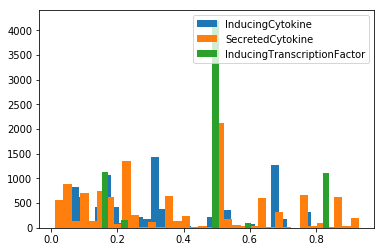

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
for c in res_train:
    plt.hist(res_train[c][2], bins=36, label=c)
    plt.legend()

In [29]:
# from IPython.display import display
# for c in res_train:
#     print(c)
#     display(res_train[c][0].learned_lf_stats())

In [33]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 30166 marginals


In [34]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine                11735
inducing_transcription_factor     6696
secreted_cytokine                11735
dtype: int64

In [29]:
# from snorkel.models import LabelKey
# for lk in session.query(LabelKey).all():
#     print(lk.name, lk.group)

In [42]:
res_lf_stats = {}
for c in classes:
    print(c)
    candidate_class = classes[c]
    L_dev = res_label[c][1][0]
    L_gold_dev = res_label[c][1][1]
    gen_model_train = res_train[c][0]
    gen_model_train.error_analysis(session, L_dev, L_gold_dev)
    res_lf_stats[c] = L_dev.lf_stats(session, L_gold_dev, gen_model_train.learned_lf_stats()['Accuracy'])
    display(res_lf_stats[c])

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.624
Neg. class accuracy: 0.846
Precision            0.5
Recall               0.624
F1                   0.555
----------------------------------------
TP: 83 | FP: 83 | TN: 457 | FN: 50



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.099554,0.099554,0.049034,9,3,14,41,0.746269,0.672289
LF_indck_comp_neg_sec,1,0.121842,0.121842,0.005944,0,0,2,80,0.975610,0.726344
LF_indck_comp_xor,2,0.300149,0.300149,0.092125,73,48,1,80,0.757426,0.701292
LF_indck_dsup_imexpresso,3,0.188707,0.188707,0.074294,14,7,15,91,0.826772,0.702899
LF_indck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.124814,0,0,27,176,0.866995,0.780000
LF_indck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.078752,0,0,7,162,0.958580,0.754316
LF_indck_heur_closer_ref,6,0.396731,0.396731,0.151560,0,0,32,235,0.880150,0.816301
LF_indck_heur_distref,7,0.230312,0.194651,0.032689,0,0,5,150,0.967742,0.776003
LF_indck_heur_kwds,8,0.548291,0.419019,0.205052,84,153,0,132,0.585366,0.709573
LF_indck_txtptn_neg_all,9,0.063893,0.052006,0.037147,0,0,5,38,0.883721,0.704392


SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.901
Neg. class accuracy: 0.861
Precision            0.471
Recall               0.901
F1                   0.619
----------------------------------------
TP: 73 | FP: 82 | TN: 510 | FN: 8



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.104012,0.104012,0.035661,22,42,0,6,0.400000,0.658997
LF_secck_comp_neg_ind,1,0.182764,0.182764,0.025260,0,0,0,123,1.000000,0.724689
LF_secck_comp_xor,2,0.300149,0.300149,0.046062,52,29,0,121,0.856436,0.705974
LF_secck_dsup_imexpresso,3,0.181278,0.181278,0.093611,23,78,0,21,0.360656,0.642716
LF_secck_heur_closer_ck_to_ct,4,0.301634,0.301634,0.053492,0,0,11,192,0.945813,0.768668
LF_secck_heur_closer_ct_to_ck,5,0.251114,0.251114,0.043091,0,0,0,169,1.000000,0.754444
LF_secck_heur_closer_ref,6,0.396731,0.396731,0.083210,0,0,11,256,0.958801,0.805371
LF_secck_heur_distref,7,0.230312,0.193165,0.044577,0,0,2,153,0.987097,0.751799
LF_secck_heur_kwds,8,0.548291,0.419019,0.127786,61,71,3,234,0.799458,0.770624
LF_secck_txtptn_neg_all,9,0.060921,0.049034,0.014859,0,0,1,40,0.975610,0.699307


InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.581
Neg. class accuracy: 0.914
Precision            0.641
Recall               0.581
F1                   0.61
----------------------------------------
TP: 50 | FP: 28 | TN: 296 | FN: 36



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.429268,0.429268,0.000000,44,23,4,105,0.846591,0.789974
LF_indtf_heur_distref,1,0.226829,0.226829,0.000000,0,0,3,90,0.967742,0.729172
LF_indtf_txtptn_neg_all,2,0.073171,0.073171,0.026829,0,0,7,23,0.766667,0.650959
LF_indtf_txtptn_pos_all,3,0.190244,0.190244,0.026829,50,28,0,0,0.641026,0.709205
